In [27]:
import nest_asyncio
import numpy as np
import pandas as pd
import pyshark
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sns.set_style("whitegrid")
nest_asyncio.apply()

In [28]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [29]:
numPcaps = 400
fileName = "pcap-run-1.pcap"

resultsFolder = Path("powerowl_example_results")
pcapsFolder = resultsFolder.joinpath("pcaps")

sourceIP = "172.16.0.2" # MTU IP

REMOVE_S_PACKETS = False
apduTypeMap = {
    '0x00000000':"I",
    '0x00000001':"S",
    '0x00000003':"U"
}
filePaths = [pcapsFolder.joinpath(f"pcap-run-{i}.pcap") for i in range(numPcaps)]
# Filter all packets that have an APCI and (if present) and ASDU 
caps = [pyshark.FileCapture(filePath, display_filter="iec60870_104", use_json=True) for filePath in filePaths]

In [30]:
def computeTopologicalMetrics(df: pd.DataFrame):
    G = nx.Graph()
    nodesArr = df["dest"].unique()    
    G.add_nodes_from(nodesArr)
    color_map = ['red' if node == sourceIP else 'blue' for node in G]
    print(len(G.nodes))
    for index, pckt in df.iterrows():
        G.add_edge(pckt["src"], pckt["dest"])

    avgDegree = np.mean([d[1] for d in list(G.degree())])
    L = nx.normalized_laplacian_matrix(G)
    e = np.linalg.eigvals(L.toarray())

    print(f"Average degree: {avgDegree:.3f}")
    print("Largest eigenvalue:", max(e))

    return avgDegree, max(e)

def computeThrPcktHour(df: pd.DataFrame):
    totSize = sum(df["length"])
    capDuration = (df.loc[len(df)-1]["timestamp"] - df.loc[0]["timestamp"])
    throughput = totSize / capDuration

    packtPerHour = (len(df)*3600) / capDuration
    print(f"Throughput: {throughput:.3f} bytes / second")
    print(f"Packet / hour: {(packtPerHour):.3f}")

    return throughput, packtPerHour

def computeIATDist(df: pd.DataFrame):
    #dfC = df[df["dest"] == sourceIP].reset_index(drop=True)

    iats = []
    for i in range(1, len(df)):
        iat = df.loc[i]["timestamp"] - df.loc[i-1]["timestamp"]
        iats.append(iat)

    return np.mean(iats), np.median(iats), np.min(iats), np.max(iats), np.percentile(iats, 25), np.percentile(iats, 75)

def computeCommandsIATDist(df: pd.DataFrame):
    hosts = df["dest"].unique()
    actuators = np.delete(hosts, np.where(hosts == sourceIP))

    iats = []
    # For each actuator, compute the IAT of commands sent to it
    # Commands are ASDU type 45
    for actuator in actuators:
        dfC = df[(df["dest"] == actuator) & (df["iec104_asdu_typeid"] == "45")]
        dfC.reset_index(drop=True, inplace=True)
        for i in range(1, len(dfC)):
            iat = dfC.loc[i]["timestamp"] - dfC.loc[i-1]["timestamp"]
            iats.append(iat)
    if len(iats) == 0:
        totSec = (df.loc[len(df)-1]["timestamp"] - df.loc[0]["timestamp"])
        iats = [totSec]
    return np.mean(iats), np.median(iats), np.min(iats), np.max(iats), np.percentile(iats, 25), np.percentile(iats, 75)

def computePacketDirection(df: pd.DataFrame):
    sns.set_theme(style="whitegrid",font_scale=1.3)
    numC2A = len(df[df["src"] == sourceIP])
    numA2C = len(df) - numC2A
    uniqueHosts = len(df["src"].unique())

    percA2C = (numA2C / (numC2A + numA2C)) * 100
    percC2A = (numC2A / (numC2A + numA2C)) * 100
    print(f"Num of unique hosts: {uniqueHosts}")
    print(f"Num a2C: {numA2C} ({percA2C:.2f}%)")
    print(f"Num C2a: {numC2A} ({percC2A:.2f}%)")

    return percA2C, percC2A

def computeBytesPerPcktDist(df: pd.DataFrame):
    return np.mean(df["length"]), np.median(df["length"]), np.min(df["length"]), np.max(df["length"]), np.percentile(df["length"], 25), np.percentile(df["length"], 75)

def computeASDUTypePerc(df: pd.DataFrame):
    counts = df["iec104_asdu_typeid"].value_counts(normalize=True)
    # Return a disctionary ASDUType: percentage
    percents = {k: v for k, v in counts.items()}
    return percents

def computeAPDUTypePerc(df: pd.DataFrame):
    iec104_type_freq = df["iec104_type"].value_counts(normalize=True)
    percents = {k: v for k, v in iec104_type_freq.items()}
    return percents

def computeSRateDist(df: pd.DataFrame):
    # S-Rate calculation
    hosts = df["dest"].unique()
    actuators = np.delete(hosts, np.where(hosts == sourceIP))

    sRates = {}
    for actuator in actuators:
        dfI = df[(df["src"] == actuator) & (df["iec104_asdu_typeid"] == "13")].reset_index(drop=True)
        dfS = df[(df["dest"] == actuator)].reset_index(drop=True)
        countI = dfI["iec104_type"].value_counts()
        countS = dfS["iec104_type"].value_counts()
        try:
            sRate = int(countI.I / countS.S)
        except AttributeError as e:
            sRate = float("NaN")

        sRates[actuator] = sRate
    sRatesVals = list(sRates.values())
    return np.nanmean(sRatesVals), np.nanmedian(sRatesVals), np.nanmin(sRatesVals), np.nanmax(sRatesVals), np.nanpercentile(sRatesVals, 25), np.nanpercentile(sRatesVals, 75)

In [31]:
from datetime import datetime
pcapFeatures = pd.DataFrame(columns=["avgDegree", "maxEigVal", "throughput", "packetsPerHour", "meanIAT", "medianIAT", "minIAT", "maxIAT", "perc25IAT", "perc75IAT",
                                     "meanCmdIAT", "medianCmdIAT", "minCmdIAT", "maxCmdIAT", "perc25CmdIAT", "perc75CmdIAT",
                                     "percA2C", "percC2A", "meanBytesPerPckt", "medianBytesPerPckt", "minBytesPerPckt", "maxBytesPerPckt", "perc25BytesPerPckt", "perc75BytesPerPckt"])
capNum = 0
for cap in caps:
    num = 0
    totSize = 0
    df = pd.DataFrame(columns=["timestamp", "length", "src", "dest", "iec104_type", "iec104_asdu_typeid"])
    pcktNum = 0
    for packet in cap:
        try:
            df.loc[num] = [datetime.timestamp(packet.sniff_time), packet.length, packet.ip.src, packet.ip.dst, apduTypeMap[packet.iec60870_104.type], str(packet.iec60870_asdu.typeid)]
        except AttributeError:
            df.loc[num] = [datetime.timestamp(packet.sniff_time), packet.length, packet.ip.src, packet.ip.dst, apduTypeMap[packet.iec60870_104.type], None]
        totSize += packet.length
        num+=1
    totSec = (df.loc[len(df)-1]["timestamp"] - df.loc[0]["timestamp"])
    print("Total seconds:", totSec)
    pcapFeaturesDict = {}
    if len(df) > 0:
        pcapFeaturesDict["avgDegree"], pcapFeaturesDict["maxEigVal"] = computeTopologicalMetrics(df)
        pcapFeaturesDict["throughput"], pcapFeaturesDict["packetsPerHour"] = computeThrPcktHour(df)
        pcapFeaturesDict["meanIAT"], pcapFeaturesDict["medianIAT"], pcapFeaturesDict["minIAT"], pcapFeaturesDict["maxIAT"], pcapFeaturesDict["perc25IAT"], pcapFeaturesDict["perc75IAT"] = computeIATDist(df)
        pcapFeaturesDict["meanCmdIAT"], pcapFeaturesDict["medianCmdIAT"], pcapFeaturesDict["minCmdIAT"], pcapFeaturesDict["maxCmdIAT"], pcapFeaturesDict["perc25CmdIAT"], pcapFeaturesDict["perc75CmdIAT"] = computeCommandsIATDist(df)
        pcapFeaturesDict["percA2C"], pcapFeaturesDict["percC2A"] = computePacketDirection(df)
        pcapFeaturesDict["meanBytesPerPckt"], pcapFeaturesDict["medianBytesPerPckt"], pcapFeaturesDict["minBytesPerPckt"], pcapFeaturesDict["maxBytesPerPckt"], pcapFeaturesDict["perc25BytesPerPckt"], pcapFeaturesDict["perc75BytesPerPckt"] = computeBytesPerPcktDist(df)
        asduTypePerc = computeASDUTypePerc(df)
        for asduType, perc in asduTypePerc.items():
            pcapFeaturesDict[f"percASDU-{asduType}"] = perc
        apduTypePerc = computeAPDUTypePerc(df)
        for apduType, perc in apduTypePerc.items():
            pcapFeaturesDict[f"percAPDU-{apduType}"] = perc
        pcapFeaturesDict["meanSRate"], pcapFeaturesDict["medianSRate"], pcapFeaturesDict["minSRate"], pcapFeaturesDict["maxSRate"], pcapFeaturesDict["perc25SRate"], pcapFeaturesDict["perc75SRate"] = computeSRateDist(df)
        pcapFeatures = pd.concat([pcapFeatures, pd.DataFrame([pcapFeaturesDict])], ignore_index=True)

pcapFeatures.to_csv(pcapsFolder.joinpath("pcap-features.csv"), index=True, index_label="pcap-num")

Total seconds: 62.24802803993225
33
Average degree: 1.939
Largest eigenvalue: 2.0000000000000004
Throughput: 3235.958 bytes / second
Packet / hour: 113989.153
Num of unique hosts: 33
Num a2C: 1678 (85.13%)
Num C2a: 293 (14.87%)


/tmp/ipykernel_1999952/3243251637.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pcapFeatures = pd.concat([pcapFeatures, pd.DataFrame([pcapFeaturesDict])], ignore_index=True)


Total seconds: 59.85035490989685
33
Average degree: 1.939
Largest eigenvalue: 2.0000000000000004
Throughput: 3009.439 bytes / second
Packet / hour: 103217.433
Num of unique hosts: 33
Num a2C: 1474 (85.90%)
Num C2a: 242 (14.10%)
Total seconds: 59.783936977386475
33
Average degree: 1.939
Largest eigenvalue: 1.9999999999999996
Throughput: 3166.904 bytes / second
Packet / hour: 110437.692
Num of unique hosts: 33
Num a2C: 1567 (85.44%)
Num C2a: 267 (14.56%)
Total seconds: 59.62107992172241
33
Average degree: 1.939
Largest eigenvalue: 1.9999999999999996
Throughput: 3463.808 bytes / second
Packet / hour: 124687.443
Num of unique hosts: 33
Num a2C: 1783 (86.34%)
Num C2a: 282 (13.66%)
Total seconds: 59.33586597442627
33
Average degree: 1.939
Largest eigenvalue: 1.9999999999999996
Throughput: 3250.715 bytes / second
Packet / hour: 114123.219
Num of unique hosts: 33
Num a2C: 1619 (86.07%)
Num C2a: 262 (13.93%)
Total seconds: 59.41227698326111
33
Average degree: 1.939
Largest eigenvalue: 1.9999999

In [32]:
# Read the discrTraces.csv file and for each line associate the AttackStrategy to a new pcapFeatures column
discrTraces = pd.read_csv(resultsFolder.joinpath("discrTraces.csv"))
pcapFeatures["AttackStrategy"] = discrTraces["AttackStrategy"]

In [33]:
# Count the number of occurrences of each AttackStrategy
pcapFeatures["AttackStrategy"].value_counts()

AttackStrategy
explicit               87
intermittent_closed    84
intermittent           79
no_action              76
intermittent_open      74
Name: count, dtype: int64

/tmp/ipykernel_1999952/3457651025.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15, 10))


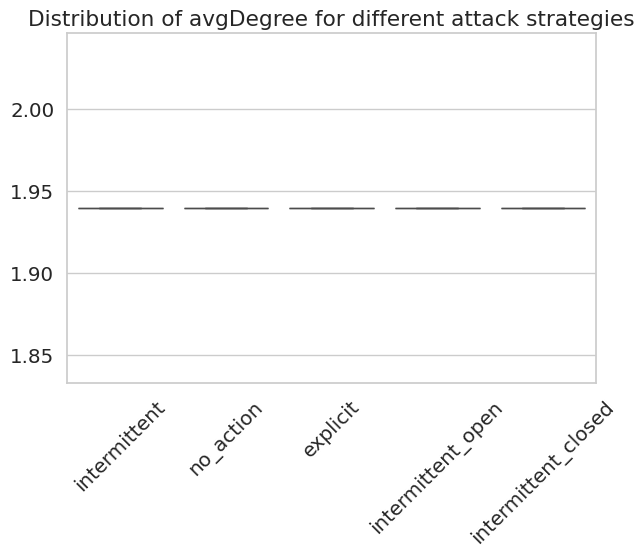

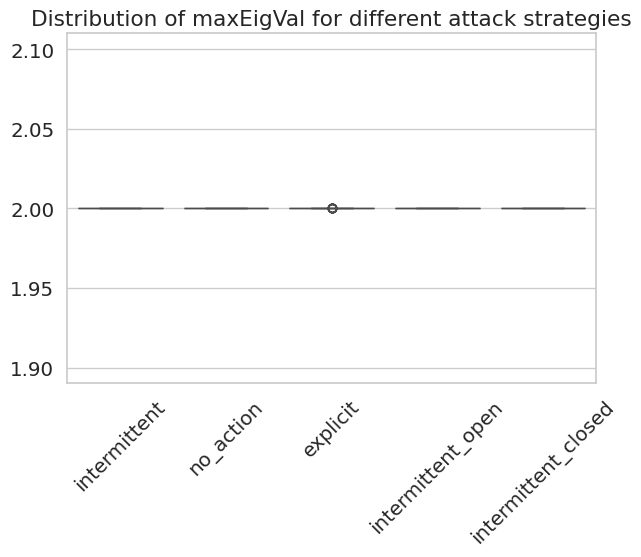

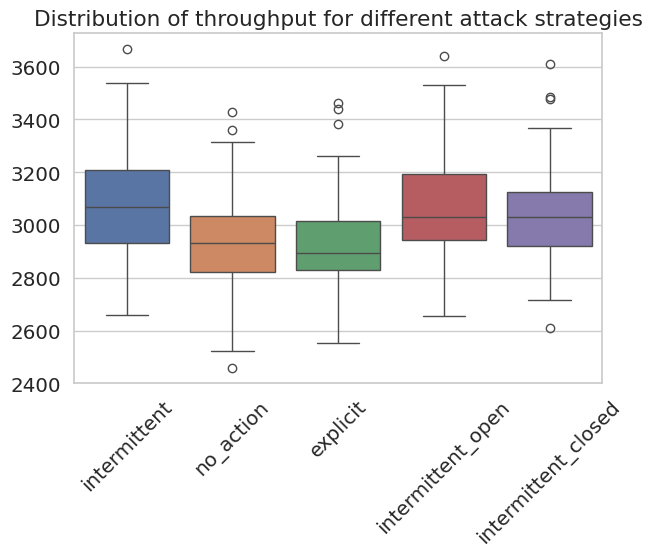

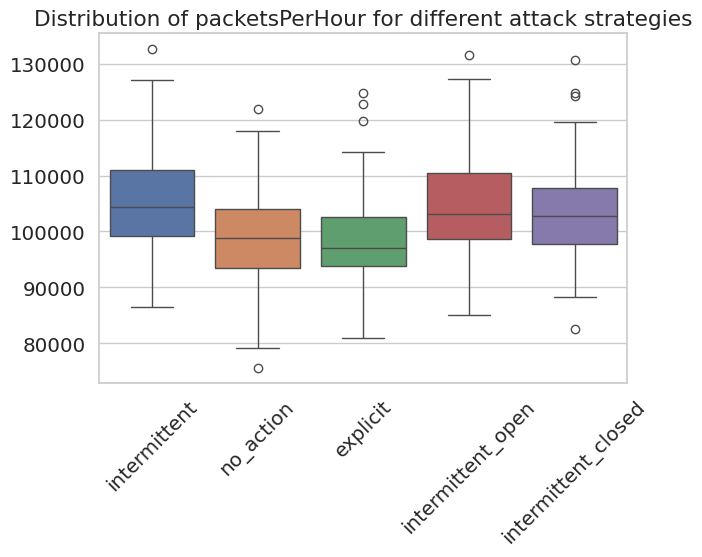

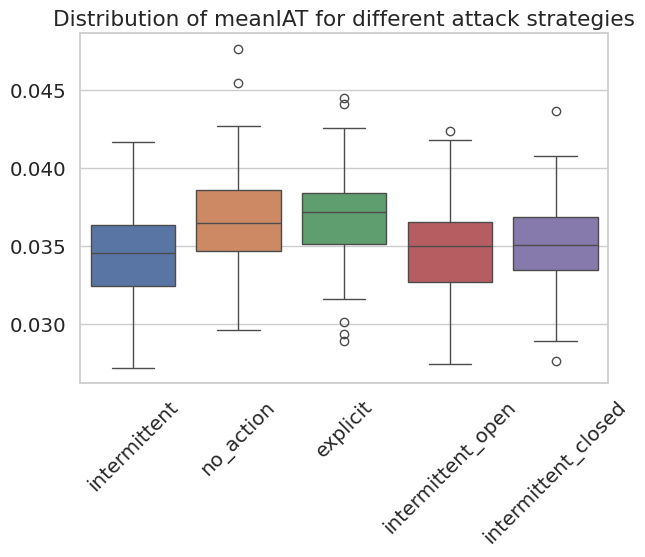

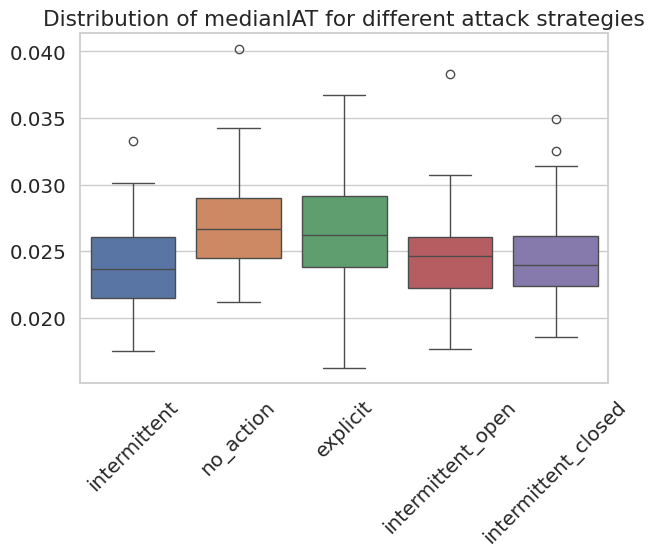

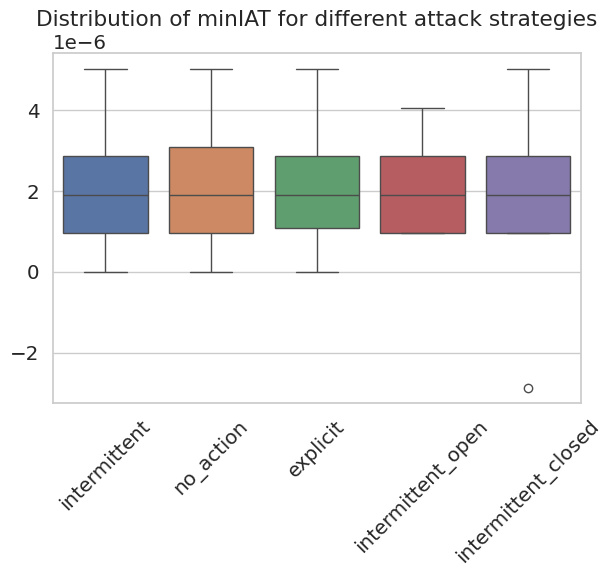

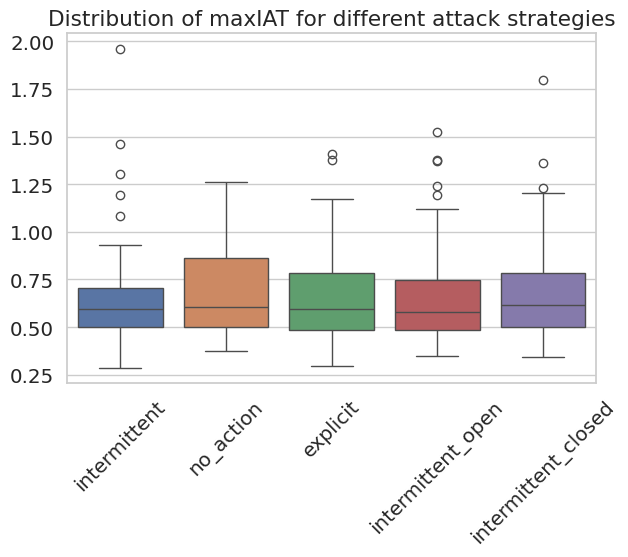

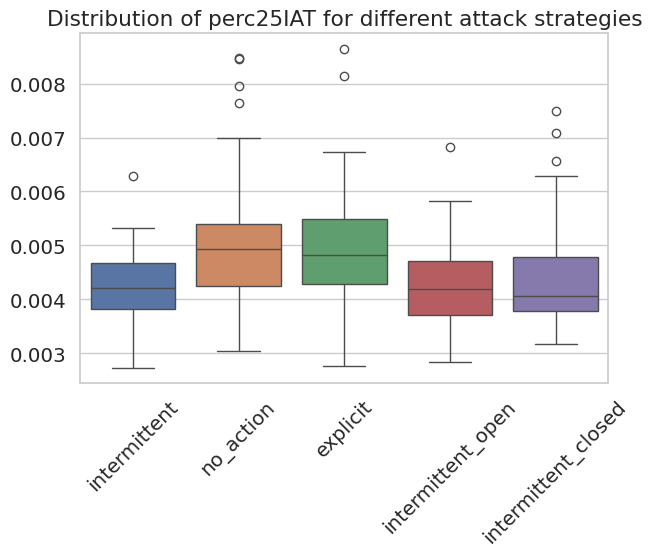

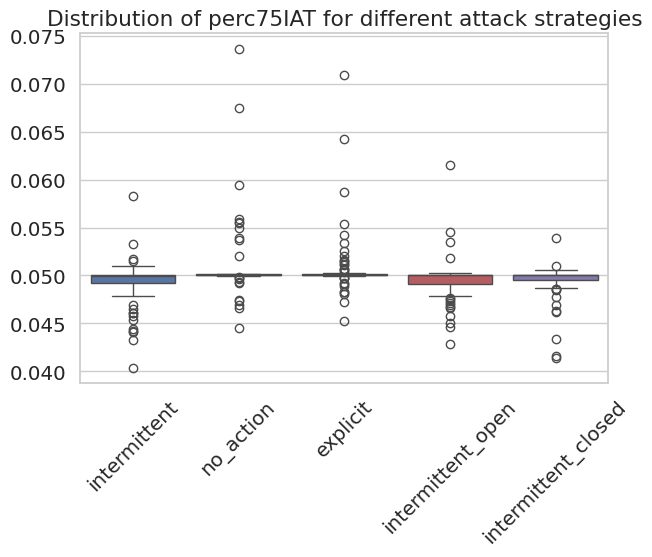

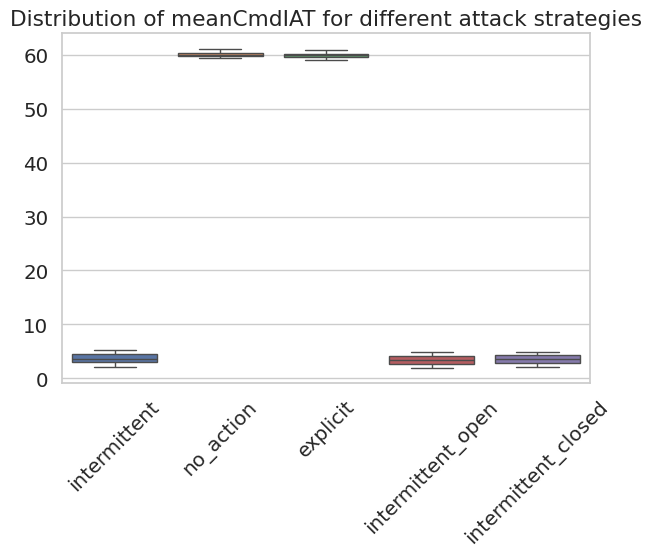

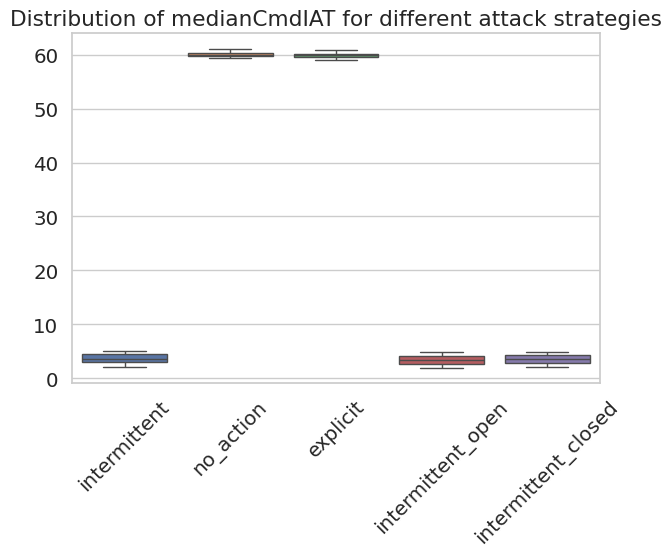

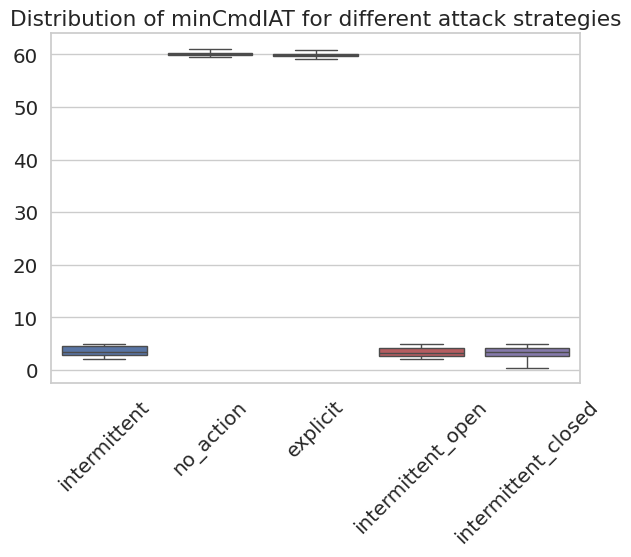

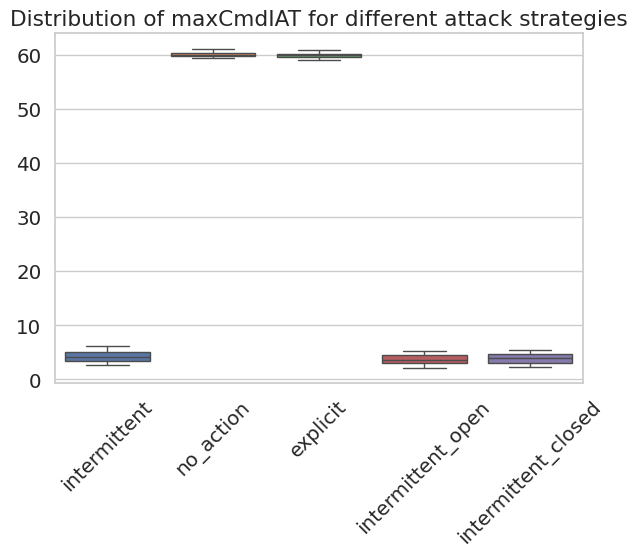

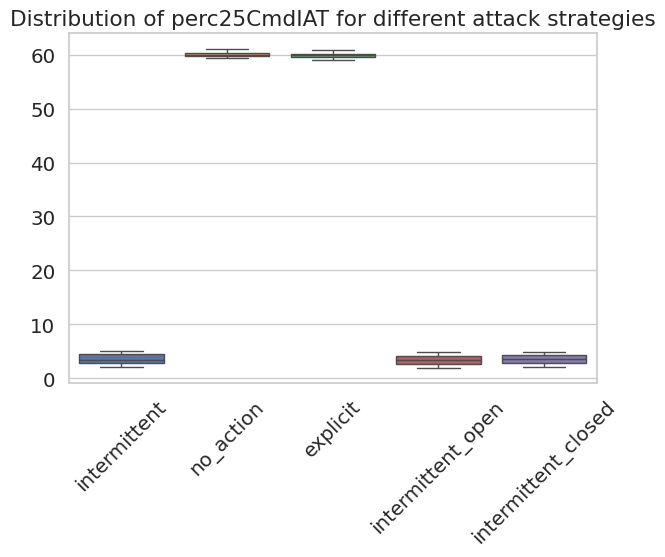

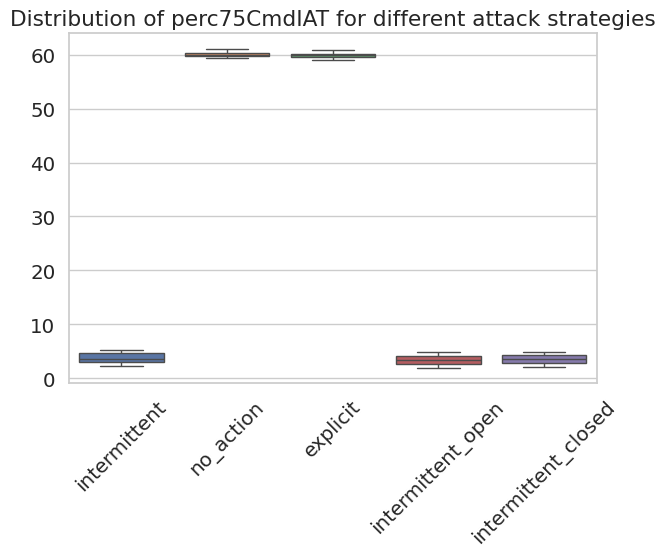

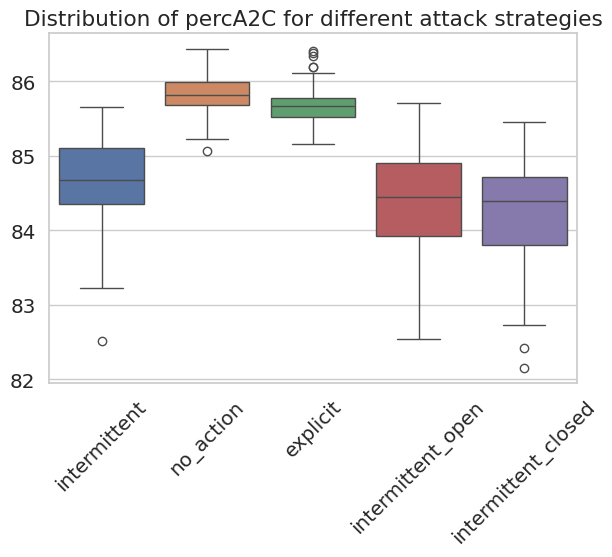

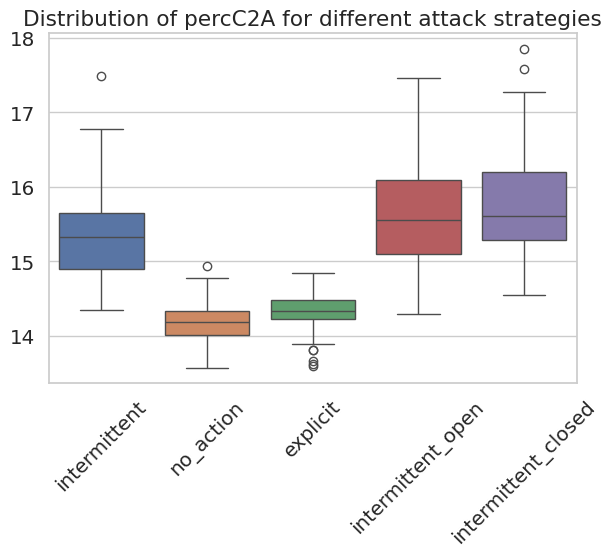

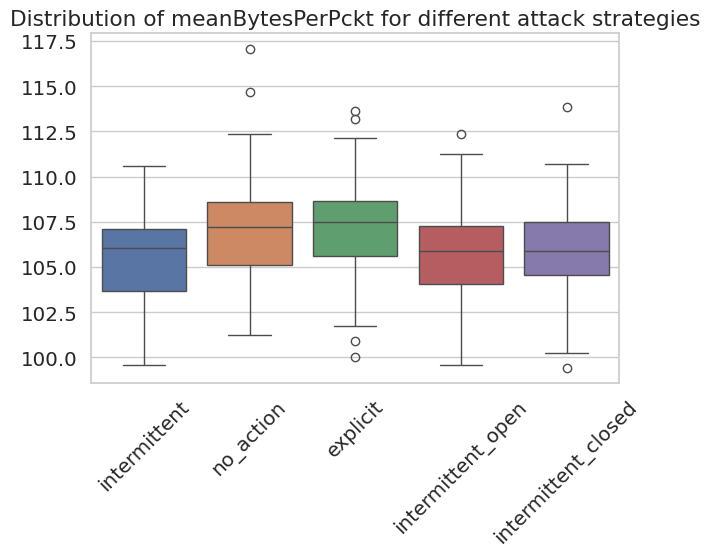

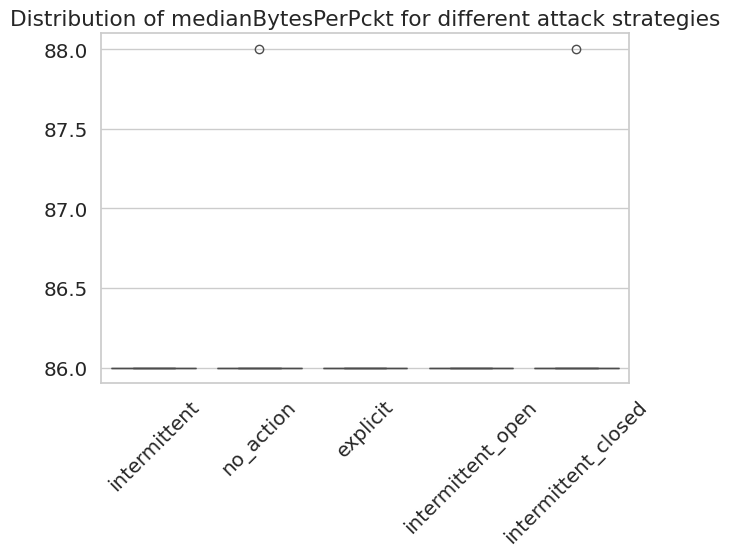

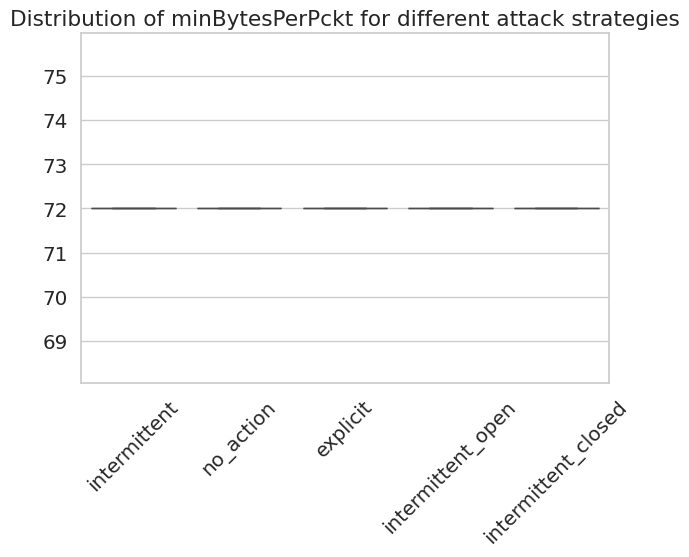

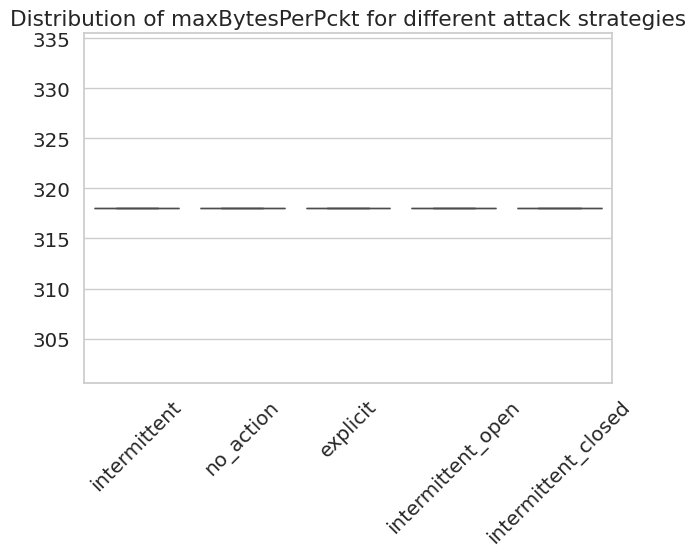

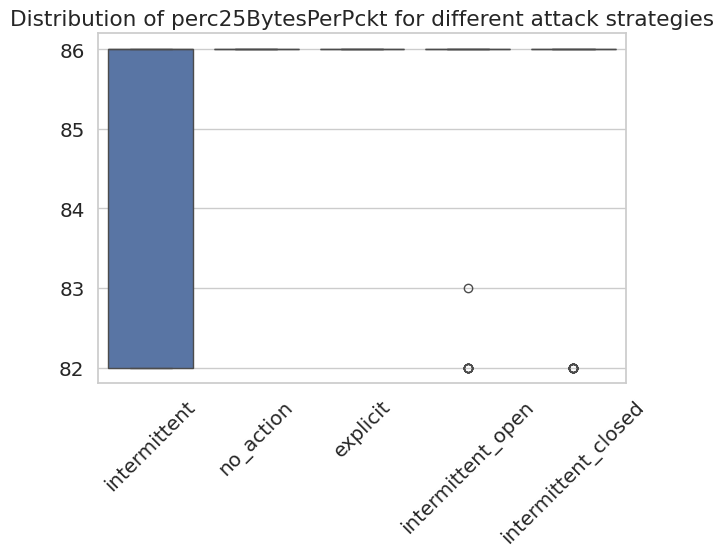

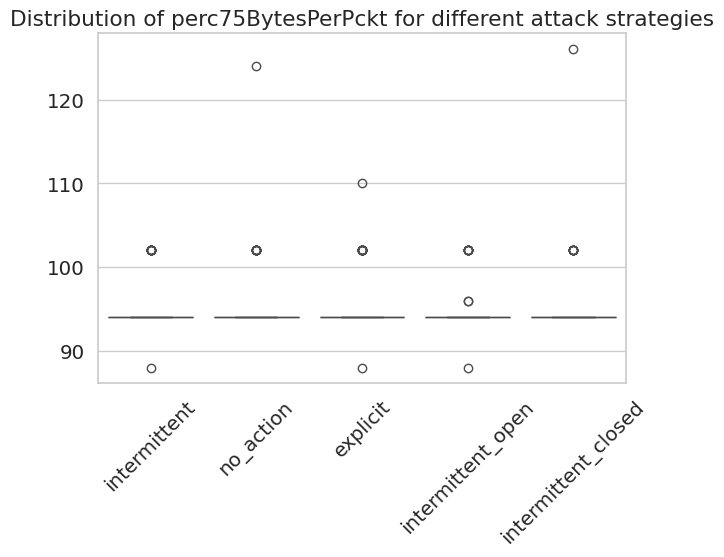

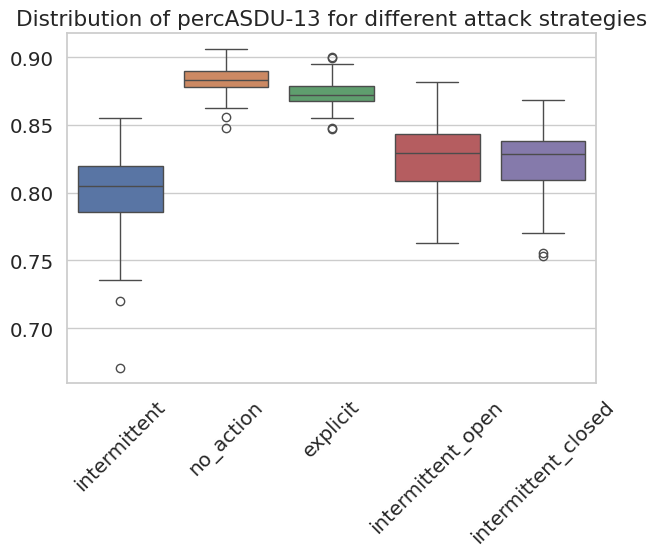

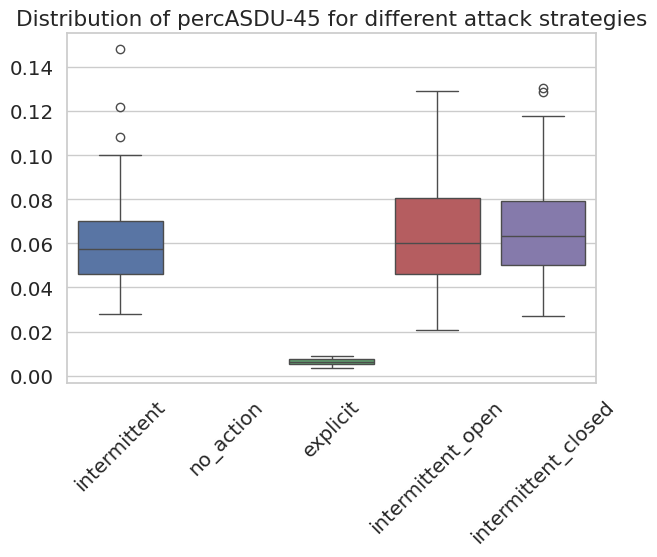

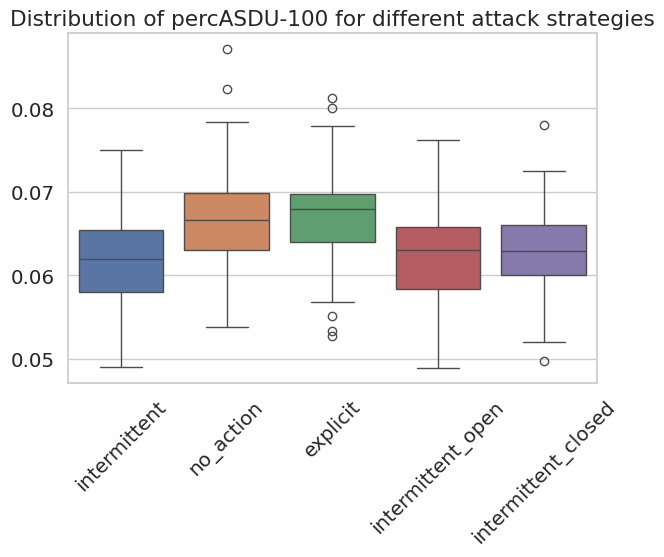

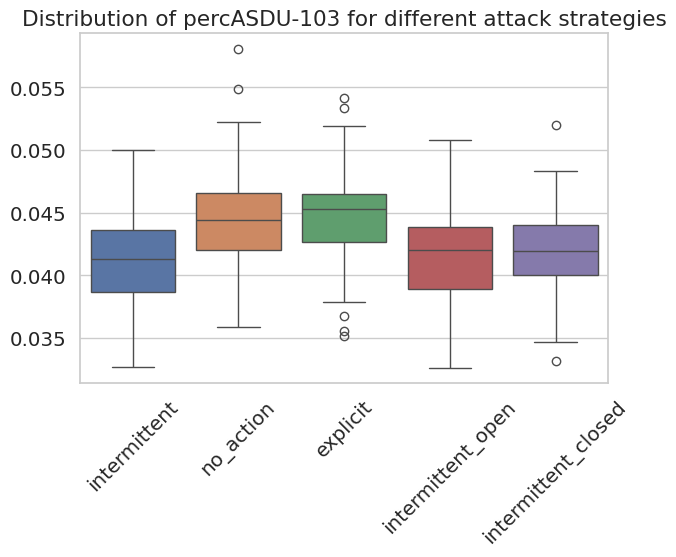

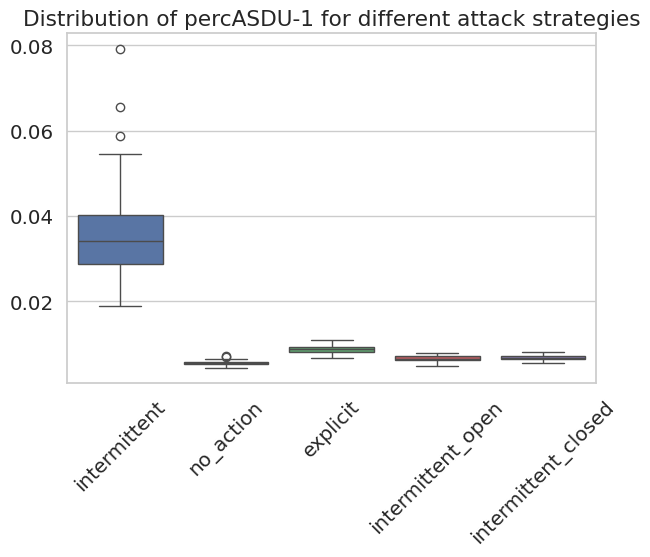

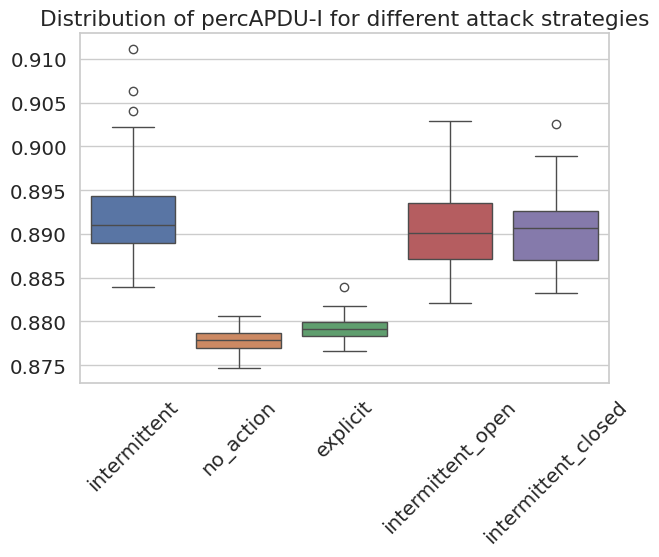

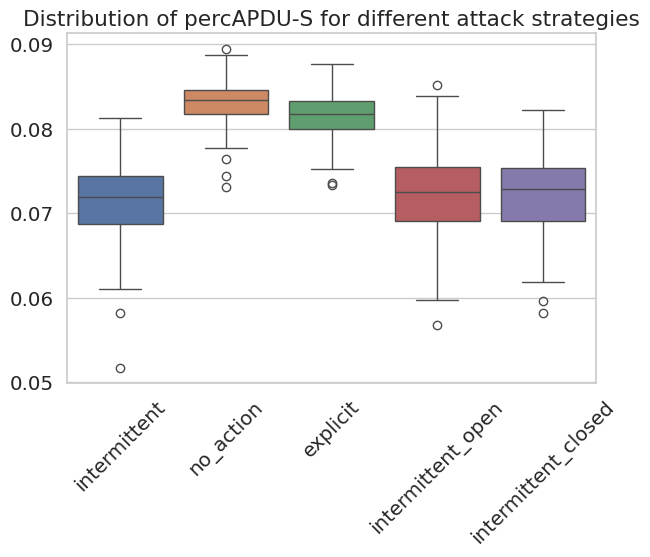

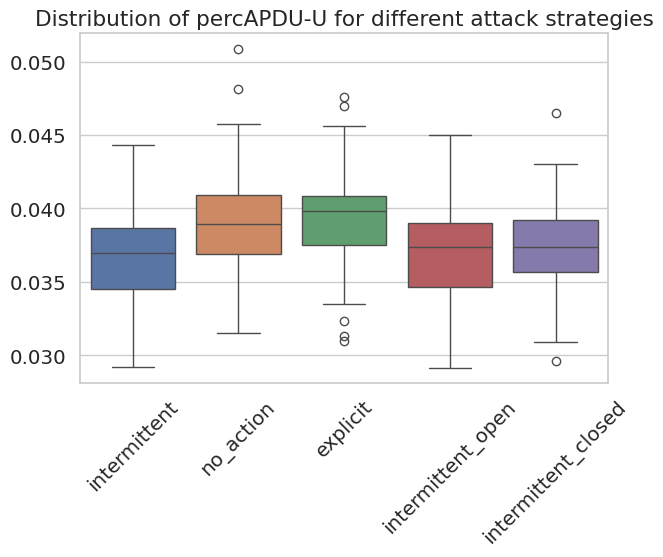

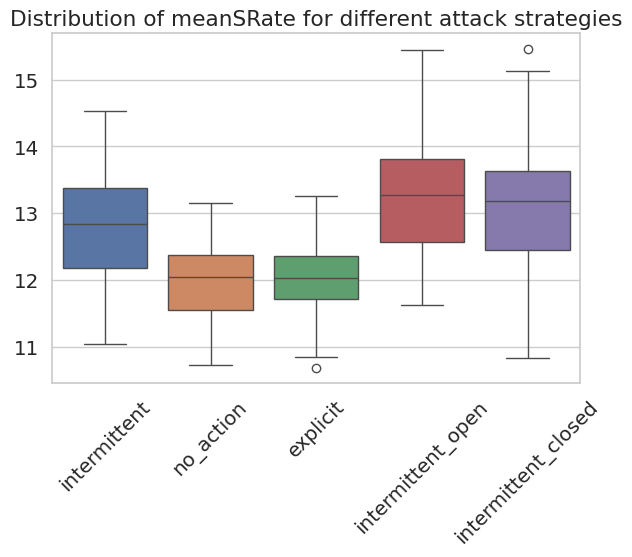

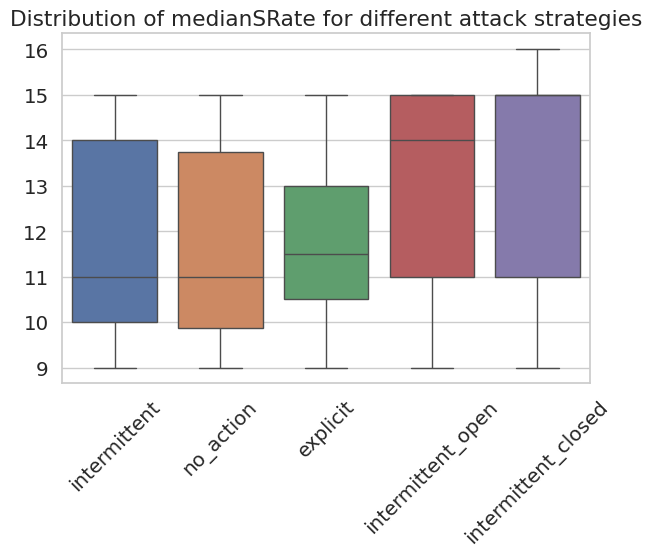

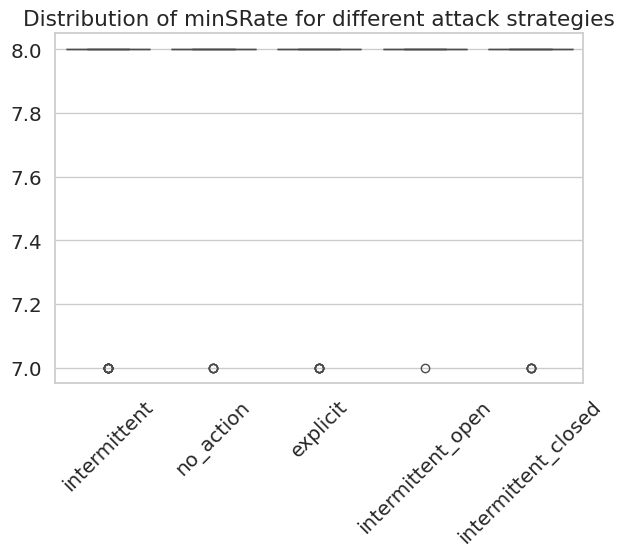

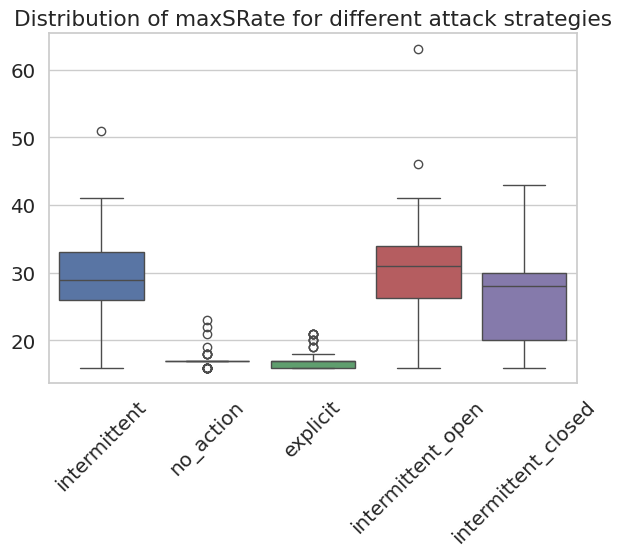

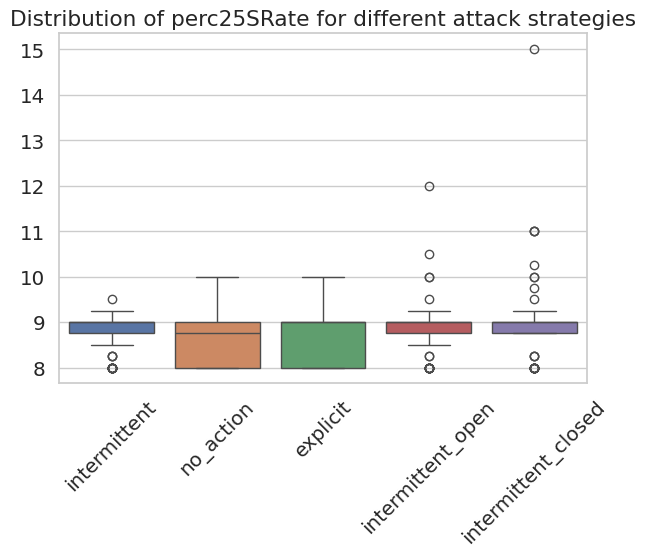

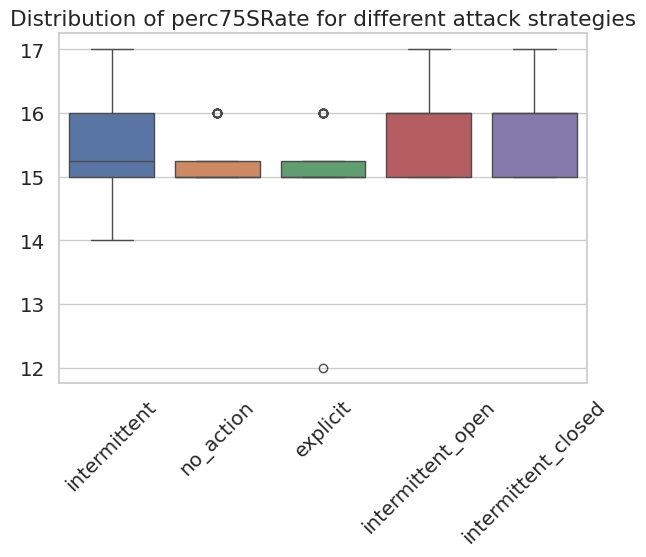

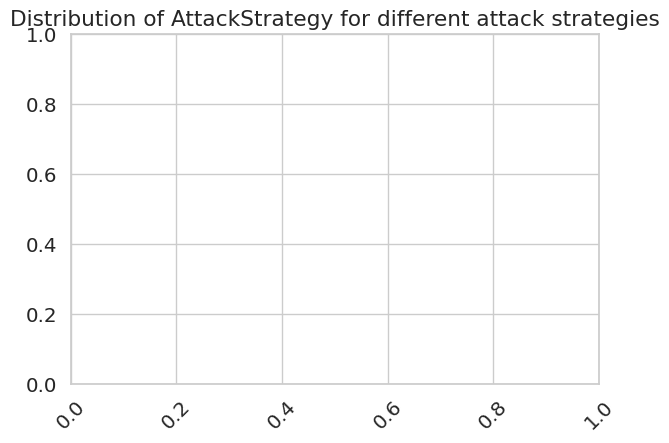

In [34]:
# Violin plot of the features
feats = pcapFeatures.columns
attackStrategies = pcapFeatures["AttackStrategy"].unique()
for feat in feats:
    pcapFeaturesComp = {}
    for strategy in attackStrategies:
        pcapFeaturesPerStrategy = pcapFeatures[pcapFeatures["AttackStrategy"] == strategy]
        pcapFeaturesComp[f"{strategy}"] = pcapFeaturesPerStrategy[feat].values.flatten()
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    sns.boxplot(data=pcapFeaturesComp)
    plt.title(f"Distribution of {feat} for different attack strategies")
    plt.xticks(rotation=45)

0      0.061224
1           NaN
2      0.029575
3      0.005495
4      0.006039
         ...   
395    0.004351
396    0.094964
397    0.067929
398    0.040059
399    0.129032
Name: percASDU-45, Length: 400, dtype: float64


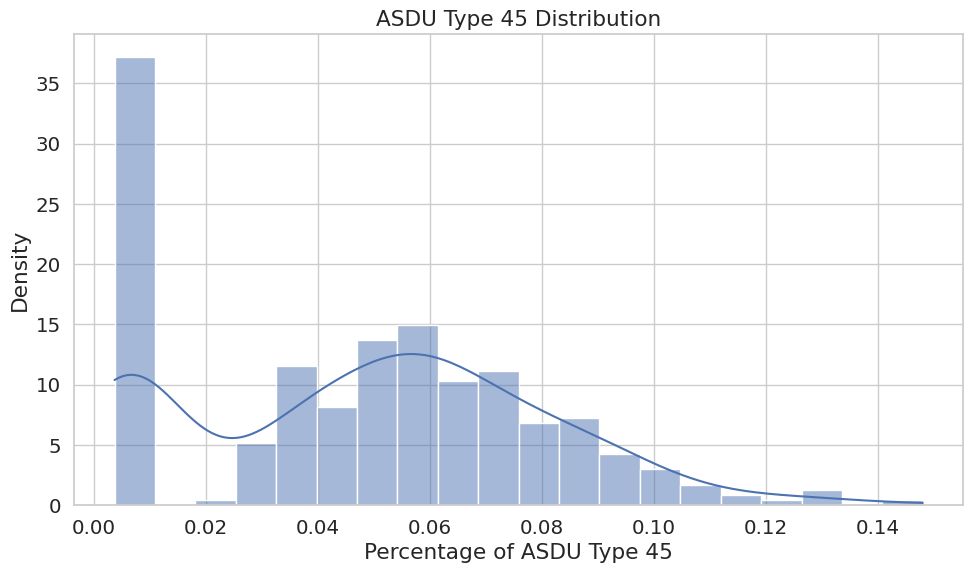

In [35]:
print(pcapFeatures["percASDU-45"])
# Plotting ASDU type distribution % (histogram as kernel density estimate)
plt.figure(figsize=(10, 6))
ax = sns.histplot(pcapFeatures["percASDU-45"], kde=True, stat="density", bins=20)
ax.set_title("ASDU Type 45 Distribution")
plt.xlabel("Percentage of ASDU Type 45")
plt.ylabel("Density")
plt.tight_layout()

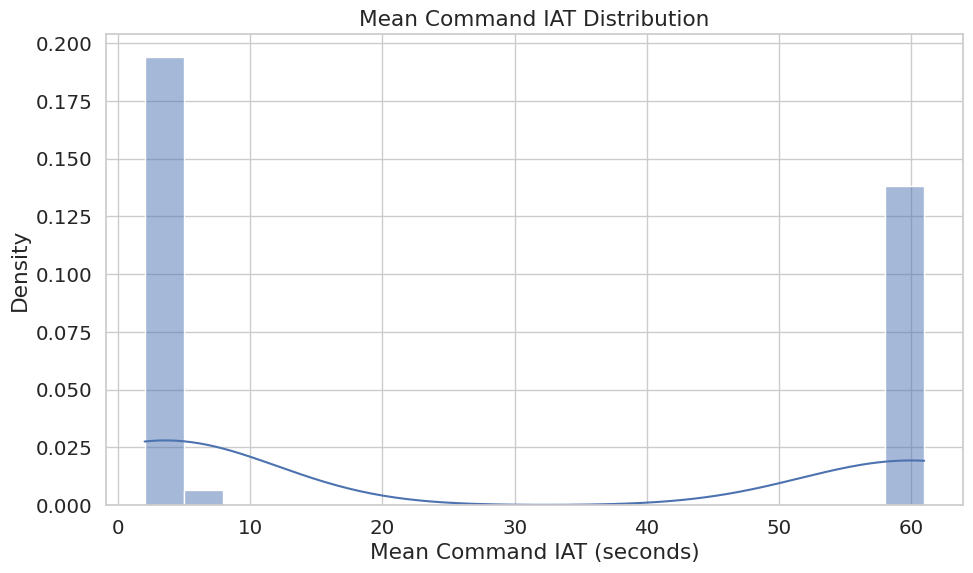

In [36]:
# meanCmdIAT distribution (histogram as kernel density estimate)
plt.figure(figsize=(10, 6))
ax = sns.histplot(pcapFeatures["meanCmdIAT"], kde=True, stat="density", bins=20)
ax.set_title("Mean Command IAT Distribution")
plt.xlabel("Mean Command IAT (seconds)")
plt.ylabel("Density")
plt.tight_layout()

Text(0, 0.5, 'Principal Component 2')

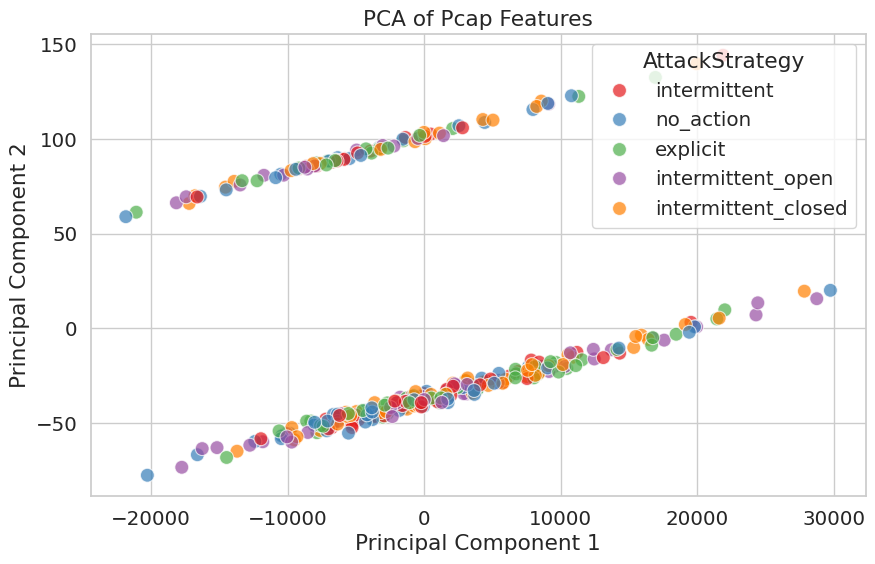

In [37]:
# Apply PCA on the features (2 principal components)
pca = PCA(n_components=2)
listCmdIAT = []#["meanCmdIAT", "medianCmdIAT", "minCmdIAT", "maxCmdIAT", "perc25CmdIAT", "perc75CmdIAT"]
pcaResult = pca.fit_transform(pcapFeatures.drop(columns=["avgDegree", "maxEigVal", "AttackStrategy"] + list(listCmdIAT)).dropna())
pcaDf = pd.DataFrame(pcaResult, columns=["PC1", "PC2"])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pcaDf, x="PC1", y="PC2", hue=pcapFeatures["AttackStrategy"], palette="Set1", s=100, alpha=0.7)
plt.title("PCA of Pcap Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

/home/loki2/wattson/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Text(0, 0.5, 't-SNE Component 2')

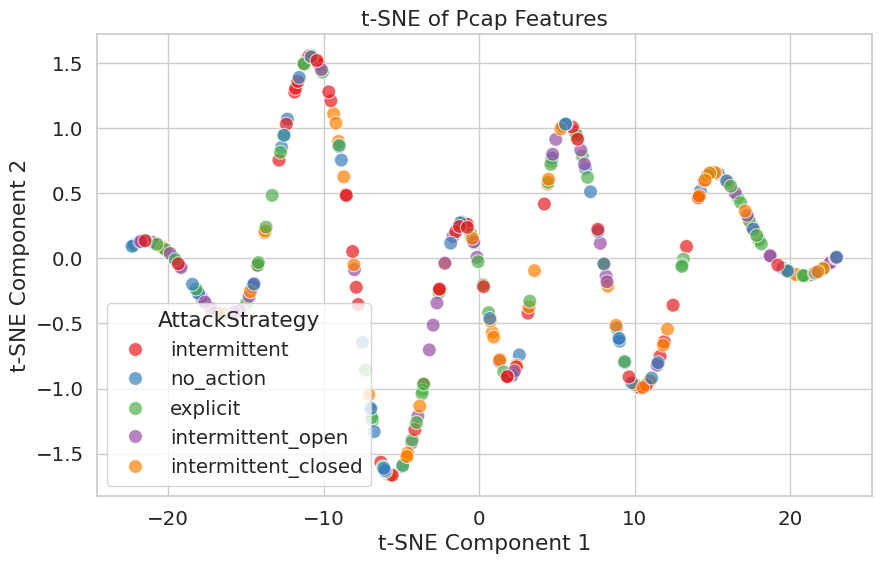

In [59]:
# Compute t-SNE on the features (2 components)
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsneResult = tsne.fit_transform(pcapFeatures.drop(columns=["avgDegree", "maxEigVal", "AttackStrategy"] + list(listCmdIAT)).dropna())
tsneDf = pd.DataFrame(tsneResult, columns=["TSNE1", "TSNE2"])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsneDf, x="TSNE1", y="TSNE2", hue=pcapFeatures["AttackStrategy"], palette="Set1", s=100, alpha=0.7)
plt.title("t-SNE of Pcap Features")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2") 

In [51]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn import preprocessing

minFeat = 1
clf = RandomForestClassifier()
cv = KFold(n_splits=5, shuffle=True, random_state=0)

rfecv = RFECV(
    estimator=clf,
    step=1,
    scoring="f1_micro",
    cv=cv,
    verbose=True,
    min_features_to_select=minFeat,
    n_jobs=8,
)

le = preprocessing.LabelEncoder()
X = pcapFeatures.drop(columns=["avgDegree", "maxEigVal", "AttackStrategy", "percASDU-1", "percAPDU-I"])
Y = le.fit_transform(pcapFeatures["AttackStrategy"])

rfecv.fit(X, Y)

print(f"Optimal number of features: {rfecv.n_features_}")

Fitting estimator with 34 features.
Fitting estimator with 34 features.
Fitting estimator with 34 features.
Fitting estimator with 34 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 33 features.
Fitting estimator with 33 features.
Fitting estimator with 33 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 32 features.
Fitting estimator with 32 features.
Fitting estimator with 32 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 31 features.
Fitting estimator with 31 features.
Fitting estimator with 31 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 30 features.
Fitting estimator with 30 features.
Fitting estimator with 30 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 29 features.
Fitting estimator with 29 fe

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'percASDU-45'),
  Text(1, 0, 'percASDU-13'),
  Text(2, 0, 'maxCmdIAT'),
  Text(3, 0, 'meanCmdIAT'),
  Text(4, 0, 'minCmdIAT'),
  Text(5, 0, 'medianCmdIAT'),
  Text(6, 0, 'percA2C'),
  Text(7, 0, 'perc25CmdIAT'),
  Text(8, 0, 'percC2A'),
  Text(9, 0, 'perc75CmdIAT')])

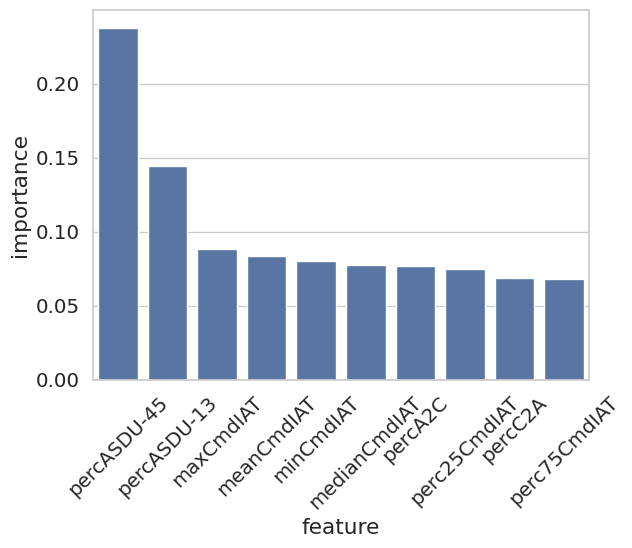

In [52]:
selFeat = pd.DataFrame(columns=["feature", "importance"])
i = 0
for selFeatIdx, col in zip(rfecv.support_, X.columns):
    if selFeatIdx:
        selFeat.loc[len(selFeat)] = {"feature": col, "importance": rfecv.estimator_.feature_importances_[i]}
        i += 1

selFeat.sort_values(by="importance", inplace=True, ascending=False)
selFeat.reset_index(inplace=True)


barPlot = sns.barplot(data=selFeat, x="feature", y="importance")
plt.xticks(rotation=45)

[0.6075 0.62   0.67   0.7    0.755  0.76   0.765  0.7625 0.76   0.7775
 0.755  0.76   0.7575 0.7625 0.725  0.7375 0.7575 0.755  0.7475 0.7425
 0.735  0.7375 0.735  0.7425 0.7675 0.75   0.755  0.765  0.7425 0.765
 0.7625 0.755  0.7425 0.75  ]


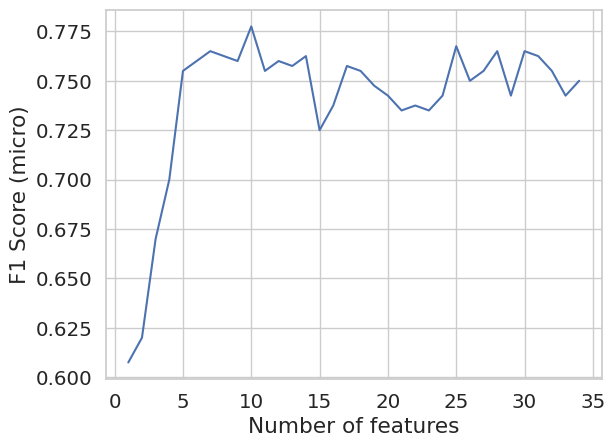

In [54]:
testScores = rfecv.cv_results_["mean_test_score"]
scoresPlot = sns.lineplot(x=rfecv.cv_results_["n_features"], y=testScores)
scoresPlot.set_xlabel("Number of features")
scoresPlot.set_ylabel("F1 Score (micro)")
print(testScores)

In [41]:
# Apply T-SNE on the features
tsne = TSNE(n_components=2, perplexity=5, n_iter=300)
tsneResult = tsne.fit_transform(pcapFeatures.drop(columns=["avgDegree", "maxEigVal", "attack-strategy"]))
tsneDf = pd.DataFrame(tsneResult, columns=["TSNE1", "TSNE2"])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsneDf, x="TSNE1", y="TSNE2", hue=pcapFeatures["attack-strategy"], palette="Set1", s=100, alpha=0.7)
plt.title("T-SNE of Pcap Features")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")

KeyError: "['attack-strategy'] not found in axis"